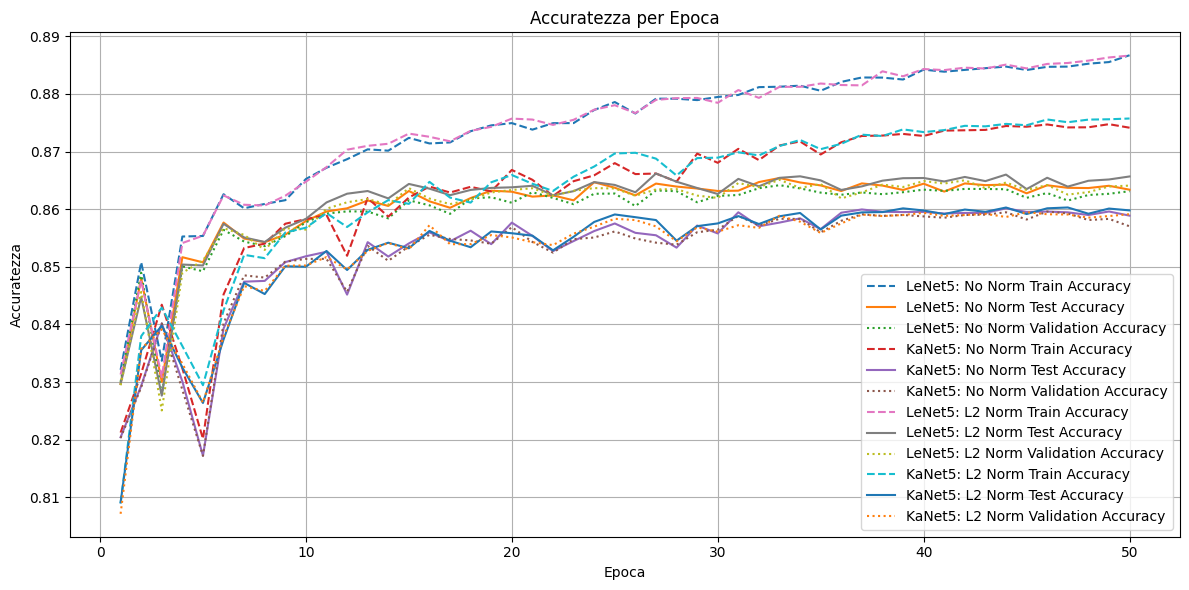

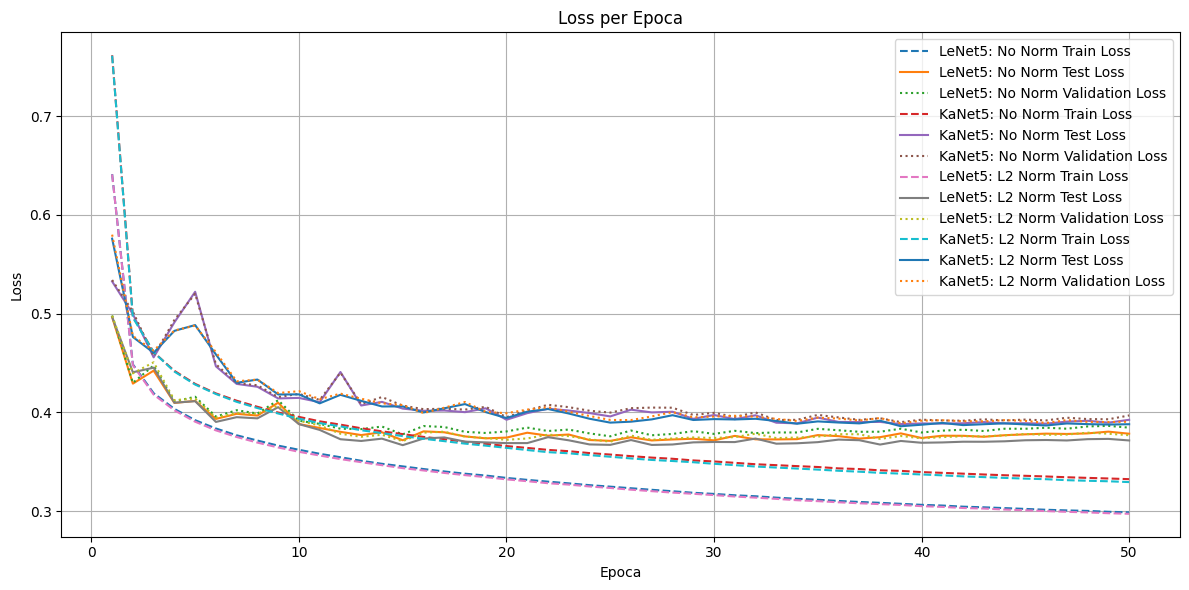

In [1]:
import os
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

# Definisci i modelli e le loro directory
models = {
    "LeNet5: No Norm": "results_None_SGD_lr0.01_0_0/Standard_LeNet5/",
    "KaNet5: No Norm": "results_None_SGD_lr0.01_5_3/KaNet5/",
    "LeNet5: L2 Norm": "results_L2_SGD_lr0.01_0_0/Standard_LeNet5/",
    "KaNet5: L2 Norm": "results_L2_SGD_lr0.01_5_3/KaNet5/"
}

# Funzione per estrarre il numero di epoca dal nome del file
def extract_epoch_number(filename):
    match = re.search(r'epoch_(\d+)', filename)
    return int(match.group(1)) if match else -1  # Ritorna -1 se non trova l'epoca

# Funzione per calcolare l'accuracy dalla matrice di confusione
def calculate_accuracy_from_confusion_matrix(conf_matrix):
    total_correct = np.trace(conf_matrix)  # Somma degli elementi diagonali (previsioni corrette)
    total_samples = np.sum(conf_matrix)    # Numero totale di campioni
    accuracy = total_correct / total_samples
    return accuracy

# Funzione per caricare le accuratezze dai file CSV
def load_accuracies(folder, phase='test'):
    accuracies = {}
    for model_name, model_dir in models.items():
        model_accuracies = []
        csv_folder = os.path.join(folder, model_dir, 'confusion_matrices_not_normalized_csv')
        
        if not os.path.exists(csv_folder):
            print(f"Directory non trovata: {csv_folder}")
            continue
        
        # Elenca tutti i file CSV che corrispondono al phase specificato
        epoch_files = [f for f in os.listdir(csv_folder) if f.startswith(f'{phase}') and f.endswith('.csv')]
        
        # Ordina i file in base al numero di epoca
        epoch_files_sorted = sorted(epoch_files, key=extract_epoch_number)
        
        for epoch_file in epoch_files_sorted:
            epoch_path = os.path.join(csv_folder, epoch_file)
            # Carica la matrice di confusione, salta la prima riga e converte in interi
            conf_matrix = pd.read_csv(epoch_path, header=None).values[1:, :].astype(int)
            accuracy = calculate_accuracy_from_confusion_matrix(conf_matrix)
            model_accuracies.append(accuracy)
        accuracies[model_name] = model_accuracies
    return accuracies

# Funzione per caricare le perdite dai file CSV
def load_losses(folder):
    losses = {}
    for model_name, model_dir in models.items():
        loss_file_path = os.path.join(folder, model_dir, 'losses.csv')
        if os.path.exists(loss_file_path):
            loss_data = pd.read_csv(loss_file_path)
            train_losses = loss_data['Train Loss'].tolist()
            test_losses = loss_data['Test Loss'].tolist()
            validation_losses = loss_data['Validation Loss'].tolist()
            losses[model_name] = {
                'train': train_losses,
                'test': test_losses,
                'val': validation_losses
            }
        else:
            print(f"File di loss non trovato: {loss_file_path}")
    return losses

# Definisci le directory principali per i modelli con e senza norma L2
standard_lenet_dir = "results/"
kan_lenet_dir = "results/"

# Carica accuratezze per train, test e validation
accuracies_train = load_accuracies(standard_lenet_dir, phase='train')
accuracies_test = load_accuracies(standard_lenet_dir, phase='test')
accuracies_val = load_accuracies(standard_lenet_dir, phase='val')

# Carica le perdite
losses = load_losses(standard_lenet_dir)

# Determina il numero di epoche (assumendo che tutti i modelli abbiano lo stesso numero di epoche)
# Prendiamo il primo modello disponibile
first_model = next(iter(accuracies_test))
num_epochs = len(accuracies_test[first_model])
epochs = list(range(1, num_epochs + 1))

# Plot dell'Accuracy
plt.figure(figsize=(12, 6))
for model in models.keys():
    if model in accuracies_train and model in accuracies_test and model in accuracies_val:
        plt.plot(epochs, accuracies_train[model], label=f'{model} Train Accuracy', linestyle='--')
        plt.plot(epochs, accuracies_test[model], label=f'{model} Test Accuracy', linestyle='-')
        plt.plot(epochs, accuracies_val[model], label=f'{model} Validation Accuracy', linestyle=':')
plt.title('Accuratezza per Epoca')
plt.xlabel('Epoca')
plt.ylabel('Accuratezza')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot della Loss
plt.figure(figsize=(12, 6))
for model in models.keys():
    if model in losses:
        plt.plot(epochs, losses[model]['train'], label=f'{model} Train Loss', linestyle='--')
        plt.plot(epochs, losses[model]['test'], label=f'{model} Test Loss', linestyle='-')
        plt.plot(epochs, losses[model]['val'], label=f'{model} Validation Loss', linestyle=':')
plt.title('Loss per Epoca')
plt.xlabel('Epoca')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [2]:
import os
import csv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.gridspec import GridSpec

def overlay_heatmap(original, heatmap, alpha=0.5, colormap='jet'):
    if heatmap.ndim == 2:
        hmin, hmax = heatmap.min(), heatmap.max()
        if hmax > 0:
            heatmap_normalized = (heatmap - hmin) / (hmax - hmin)
        else:
            heatmap_normalized = np.zeros_like(heatmap)
        cmap = plt.get_cmap(colormap)
        heatmap_colored = cmap(heatmap_normalized)[..., :3]
    else:
        heatmap_normalized = heatmap / heatmap.max()
        heatmap_colored = heatmap / heatmap.max()
    
    overlayed = (1 - alpha) * original + alpha * heatmap_colored
    overlayed = np.clip(overlayed, 0, 1)
    return overlayed, heatmap_normalized

def produce_final_chart(sample_index, 
                        correct_class_idx, 
                        pred_class_11, pred_class_12, pred_class_21, pred_class_22, 
                        class_mapping):
    dir_11 = "results/results_None_SGD_lr0.01_0_0/Standard_LeNet5/GradCAM/"
    dir_12 = "results/results_None_SGD_lr0.01_5_3/KaNet5/GradCAM/"
    dir_21 = "results/results_L2_SGD_lr0.01_0_0/Standard_LeNet5/GradCAM/"
    dir_22 = "results/results_L2_SGD_lr0.01_5_3/KaNet5/GradCAM/"

    original_path = os.path.join(dir_11, f"sample_{sample_index}_original.png")
    heatmap_11_path = os.path.join(dir_11, f"sample_{sample_index}_heatmap.png")
    heatmap_12_path = os.path.join(dir_12, f"sample_{sample_index}_heatmap.png")
    heatmap_21_path = os.path.join(dir_21, f"sample_{sample_index}_heatmap.png")
    heatmap_22_path = os.path.join(dir_22, f"sample_{sample_index}_heatmap.png")

    for path in [original_path, heatmap_11_path, heatmap_12_path, heatmap_21_path, heatmap_22_path]:
        if not os.path.exists(path):
            print(f"File mancante: {path}. Salto campione {sample_index}.")
            return

    original_img = plt.imread(original_path)
    if original_img.ndim == 2:
        original_img = np.stack([original_img]*3, axis=-1)
    if original_img.max() > 1:
        original_img = original_img / 255.0

    def normalize_if_needed(img):
        if img.ndim == 3 and img.shape[2] == 3 and img.max() > 1:
            return img / 255.0
        elif img.ndim == 2 and img.max() > 1:
            return img / 255.0
        return img

    heatmap_11 = normalize_if_needed(plt.imread(heatmap_11_path))
    heatmap_12 = normalize_if_needed(plt.imread(heatmap_12_path))
    heatmap_21 = normalize_if_needed(plt.imread(heatmap_21_path))
    heatmap_22 = normalize_if_needed(plt.imread(heatmap_22_path))

    overlayed_11, heatmap_norm_11 = overlay_heatmap(original_img, heatmap_11)
    overlayed_12, heatmap_norm_12 = overlay_heatmap(original_img, heatmap_12)
    overlayed_21, heatmap_norm_21 = overlay_heatmap(original_img, heatmap_21)
    overlayed_22, heatmap_norm_22 = overlay_heatmap(original_img, heatmap_22)

    correct_char = class_mapping.get(correct_class_idx, "Unknown")
    p11_char = class_mapping.get(pred_class_11, "Unknown")
    p12_char = class_mapping.get(pred_class_12, "Unknown")
    p21_char = class_mapping.get(pred_class_21, "Unknown")
    p22_char = class_mapping.get(pred_class_22, "Unknown")

    model_11_name = "LeNet5: No Norm"
    model_12_name = "KaNet5: No Norm"
    model_21_name = "LeNet5: L2 Norm"
    model_22_name = "KaNet5: L2 Norm"

    fig = plt.figure(figsize=(16, 12))
    # Riduciamo l'altezza della riga del titolo a 0.2
    gs = GridSpec(5, 4, figure=fig, height_ratios=[0.2,4,2,2,0.5])

    # Riduciamo hspace e aumentiamo top per meno spazio verticale
    fig.subplots_adjust(wspace=0, hspace=0.25, left=0.07, right=0.93, top=0.95, bottom=0.08)

    # Riga 0: Titolo con meno spazio verticale
    ax_text = fig.add_subplot(gs[0, :])
    ax_text.text(0.5, 0.5, f"Original Image - Correct Class: {correct_char}", 
                 ha='center', va='center', fontsize=16)
    ax_text.axis('off')

    # Riga 1: Immagine originale grande
    ax_original = fig.add_subplot(gs[1, :])
    ax_original.imshow(original_img)
    ax_original.axis('off')

    models_info = [
        (overlayed_11, heatmap_norm_11, model_11_name, p11_char),
        (overlayed_12, heatmap_norm_12, model_12_name, p12_char),
        (overlayed_21, heatmap_norm_21, model_21_name, p21_char),
        (overlayed_22, heatmap_norm_22, model_22_name, p22_char)
    ]

    # Riga 2: modelli 1 e 2 (colonne adiacenti)
    # Riga 3: modelli 3 e 4 (colonne adiacenti)
    for idx, (overlay, hmap_norm, model_name, pred_char) in enumerate(models_info):
        row = 2 if idx < 2 else 3
        start_col = 0 if (idx % 2 == 0) else 2

        ax_overlay = fig.add_subplot(gs[row, start_col])
        ax_overlay.imshow(overlay)
        ax_overlay.set_title(f"{model_name}\nPredicted Class: {pred_char}", fontsize=12)
        ax_overlay.axis('off')

        ax_heatmap = fig.add_subplot(gs[row, start_col+1])
        ax_heatmap.imshow(hmap_norm, cmap='jet')
        ax_heatmap.set_title(f"{model_name} Heatmap", fontsize=12)
        ax_heatmap.axis('off')

    # Riga 4: Colorbar
    cbar_ax = fig.add_subplot(gs[4, :])
    norm = plt.Normalize(vmin=0, vmax=1)
    cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap='jet'), cax=cbar_ax, orientation='horizontal')
    cbar.set_label('Heatmap Intensity', fontsize=14)
    cbar.ax.tick_params(labelsize=12)

    save_path = f"final_chart_sample_{sample_index}.png"
    plt.savefig(save_path, dpi=150)
    plt.close(fig)
    print(f"Chart salvato in: {save_path}")

def get_emnist_class_mapping():
    characters = list("0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz")
    return {i: char for i, char in enumerate(characters)}

def main():
    model_configs = [
        {
            "name": "LeNet5: No Norm",
            "gradcam_dir": "results/results_None_SGD_lr0.01_0_0/Standard_LeNet5/GradCAM/",
        },
        {
            "name": "KaNet5: No Norm",
            "gradcam_dir": "results/results_None_SGD_lr0.01_5_3/KaNet5/GradCAM/",
        },
        {
            "name": "LeNet5: L2 Norm",
            "gradcam_dir": "results/results_L2_SGD_lr0.01_0_0/Standard_LeNet5/GradCAM/",
        },
        {
            "name": "KaNet5: L2 Norm",
            "gradcam_dir": "results/results_L2_SGD_lr0.01_5_3/KaNet5/GradCAM/",
        }
    ]

    class_mapping = get_emnist_class_mapping()
    model_predictions = {config["name"]: {} for config in model_configs}

    for config in model_configs:
        model_name = config["name"]
        gradcam_dir = config["gradcam_dir"]
        predictions_csv = os.path.join(gradcam_dir, "predictions.csv")

        if not os.path.exists(predictions_csv):
            print(f"File {predictions_csv} non trovato per {model_name}.")
            continue

        with open(predictions_csv, 'r') as csvfile:
            reader = csv.DictReader(csvfile)
            for row in reader:
                try:
                    sample_index = int(row['sample_index'])
                    correct_class = row['correct_class']
                    predicted_class = row['predicted_class']

                    correct_class_idx = next((k for k, v in class_mapping.items() if v == correct_class), None)
                    pred_class_idx = next((k for k, v in class_mapping.items() if v == predicted_class), None)
                    if correct_class_idx is not None and pred_class_idx is not None:
                        model_predictions[model_name][sample_index] = {
                            "correct_class_idx": correct_class_idx,
                            "pred_class_idx": pred_class_idx
                        }
                except Exception as e:
                    print(f"Errore nella lettura della riga {row}: {e}")

    required_categories = {
        "misclass_model_1_only": [],
        "misclass_model_2_only": [],
        "misclass_model_3_only": [],
        "misclass_model_4_only": [],
        "misclass_all": [],
        "correct_all": []
    }

    required_counts = {
        "misclass_model_1_only": 1,
        "misclass_model_2_only": 1,
        "misclass_model_3_only": 1,
        "misclass_model_4_only": 1,
        "misclass_all": 1,
        "correct_all": 2
    }

    found = {cat:0 for cat in required_counts}
    all_sample_indices = set()
    for preds in model_predictions.values():
        all_sample_indices.update(preds.keys())

    for sample_index in all_sample_indices:
        if not all(sample_index in model_predictions[m["name"]] for m in model_configs):
            continue

        preds = [model_predictions[m["name"]][sample_index]["pred_class_idx"] for m in model_configs]
        correct_class_idx = model_predictions[model_configs[0]["name"]][sample_index]["correct_class_idx"]

        misclass_flags = [p != correct_class_idx for p in preds]

        misclass_model_1, misclass_model_2, misclass_model_3, misclass_model_4 = misclass_flags

        if (misclass_model_1 and not misclass_model_2 and not misclass_model_3 and not misclass_model_4 
            and found["misclass_model_1_only"] < required_counts["misclass_model_1_only"]):
            required_categories["misclass_model_1_only"].append(sample_index)
            found["misclass_model_1_only"] += 1
            continue

        if (misclass_model_2 and not misclass_model_1 and not misclass_model_3 and not misclass_model_4 
            and found["misclass_model_2_only"] < required_counts["misclass_model_2_only"]):
            required_categories["misclass_model_2_only"].append(sample_index)
            found["misclass_model_2_only"] += 1
            continue

        if (misclass_model_3 and not misclass_model_1 and not misclass_model_2 and not misclass_model_4 
            and found["misclass_model_3_only"] < required_counts["misclass_model_3_only"]):
            required_categories["misclass_model_3_only"].append(sample_index)
            found["misclass_model_3_only"] += 1
            continue

        if (misclass_model_4 and not misclass_model_1 and not misclass_model_2 and not misclass_model_3 
            and found["misclass_model_4_only"] < required_counts["misclass_model_4_only"]):
            required_categories["misclass_model_4_only"].append(sample_index)
            found["misclass_model_4_only"] += 1
            continue

        if (misclass_model_1 and misclass_model_2 and misclass_model_3 and misclass_model_4 
            and found["misclass_all"] < required_counts["misclass_all"]):
            required_categories["misclass_all"].append(sample_index)
            found["misclass_all"] += 1
            continue

        if (not misclass_model_1 and not misclass_model_2 and not misclass_model_3 and not misclass_model_4 
            and found["correct_all"] < required_counts["correct_all"]):
            required_categories["correct_all"].append(sample_index)
            found["correct_all"] += 1
            continue

        if all(found[cat] >= required_counts[cat] for cat in required_categories):
            print("Tutti i campioni richiesti sono stati trovati.")
            break

    for cat, count in required_counts.items():
        if found[cat] < count:
            print(f"Attenzione: Solo {found[cat]} campioni trovati per la categoria '{cat}', richiesta {count}.")
        else:
            print(f"Tutti i campioni richiesti per la categoria '{cat}' sono stati trovati.")

    selected_indices = []
    for cat in required_categories:
        selected_indices.extend(required_categories[cat])

    selected_indices = sorted(selected_indices)
    print(f"\nIndici dei campioni selezionati: {selected_indices}\n")

    for sample_index in selected_indices:
        pred_class_11 = model_predictions["LeNet5: No Norm"][sample_index]["pred_class_idx"]
        pred_class_12 = model_predictions["KaNet5: No Norm"][sample_index]["pred_class_idx"]
        pred_class_21 = model_predictions["LeNet5: L2 Norm"][sample_index]["pred_class_idx"]
        pred_class_22 = model_predictions["KaNet5: L2 Norm"][sample_index]["pred_class_idx"]

        correct_class_idx = model_predictions["LeNet5: No Norm"][sample_index]["correct_class_idx"]

        produce_final_chart(sample_index, correct_class_idx, pred_class_11, pred_class_12, pred_class_21, pred_class_22, class_mapping)

    print("\nGenerazione dei grafici finali completata.")

if __name__ == "__main__":
    main()

Tutti i campioni richiesti per la categoria 'misclass_model_1_only' sono stati trovati.
Tutti i campioni richiesti per la categoria 'misclass_model_2_only' sono stati trovati.
Tutti i campioni richiesti per la categoria 'misclass_model_3_only' sono stati trovati.
Tutti i campioni richiesti per la categoria 'misclass_model_4_only' sono stati trovati.
Tutti i campioni richiesti per la categoria 'misclass_all' sono stati trovati.
Tutti i campioni richiesti per la categoria 'correct_all' sono stati trovati.

Indici dei campioni selezionati: [0, 1, 2, 49, 52, 65, 100]

Chart salvato in: final_chart_sample_0.png
Chart salvato in: final_chart_sample_1.png
Chart salvato in: final_chart_sample_2.png
Chart salvato in: final_chart_sample_49.png
Chart salvato in: final_chart_sample_52.png
Chart salvato in: final_chart_sample_65.png
Chart salvato in: final_chart_sample_100.png

Generazione dei grafici finali completata.


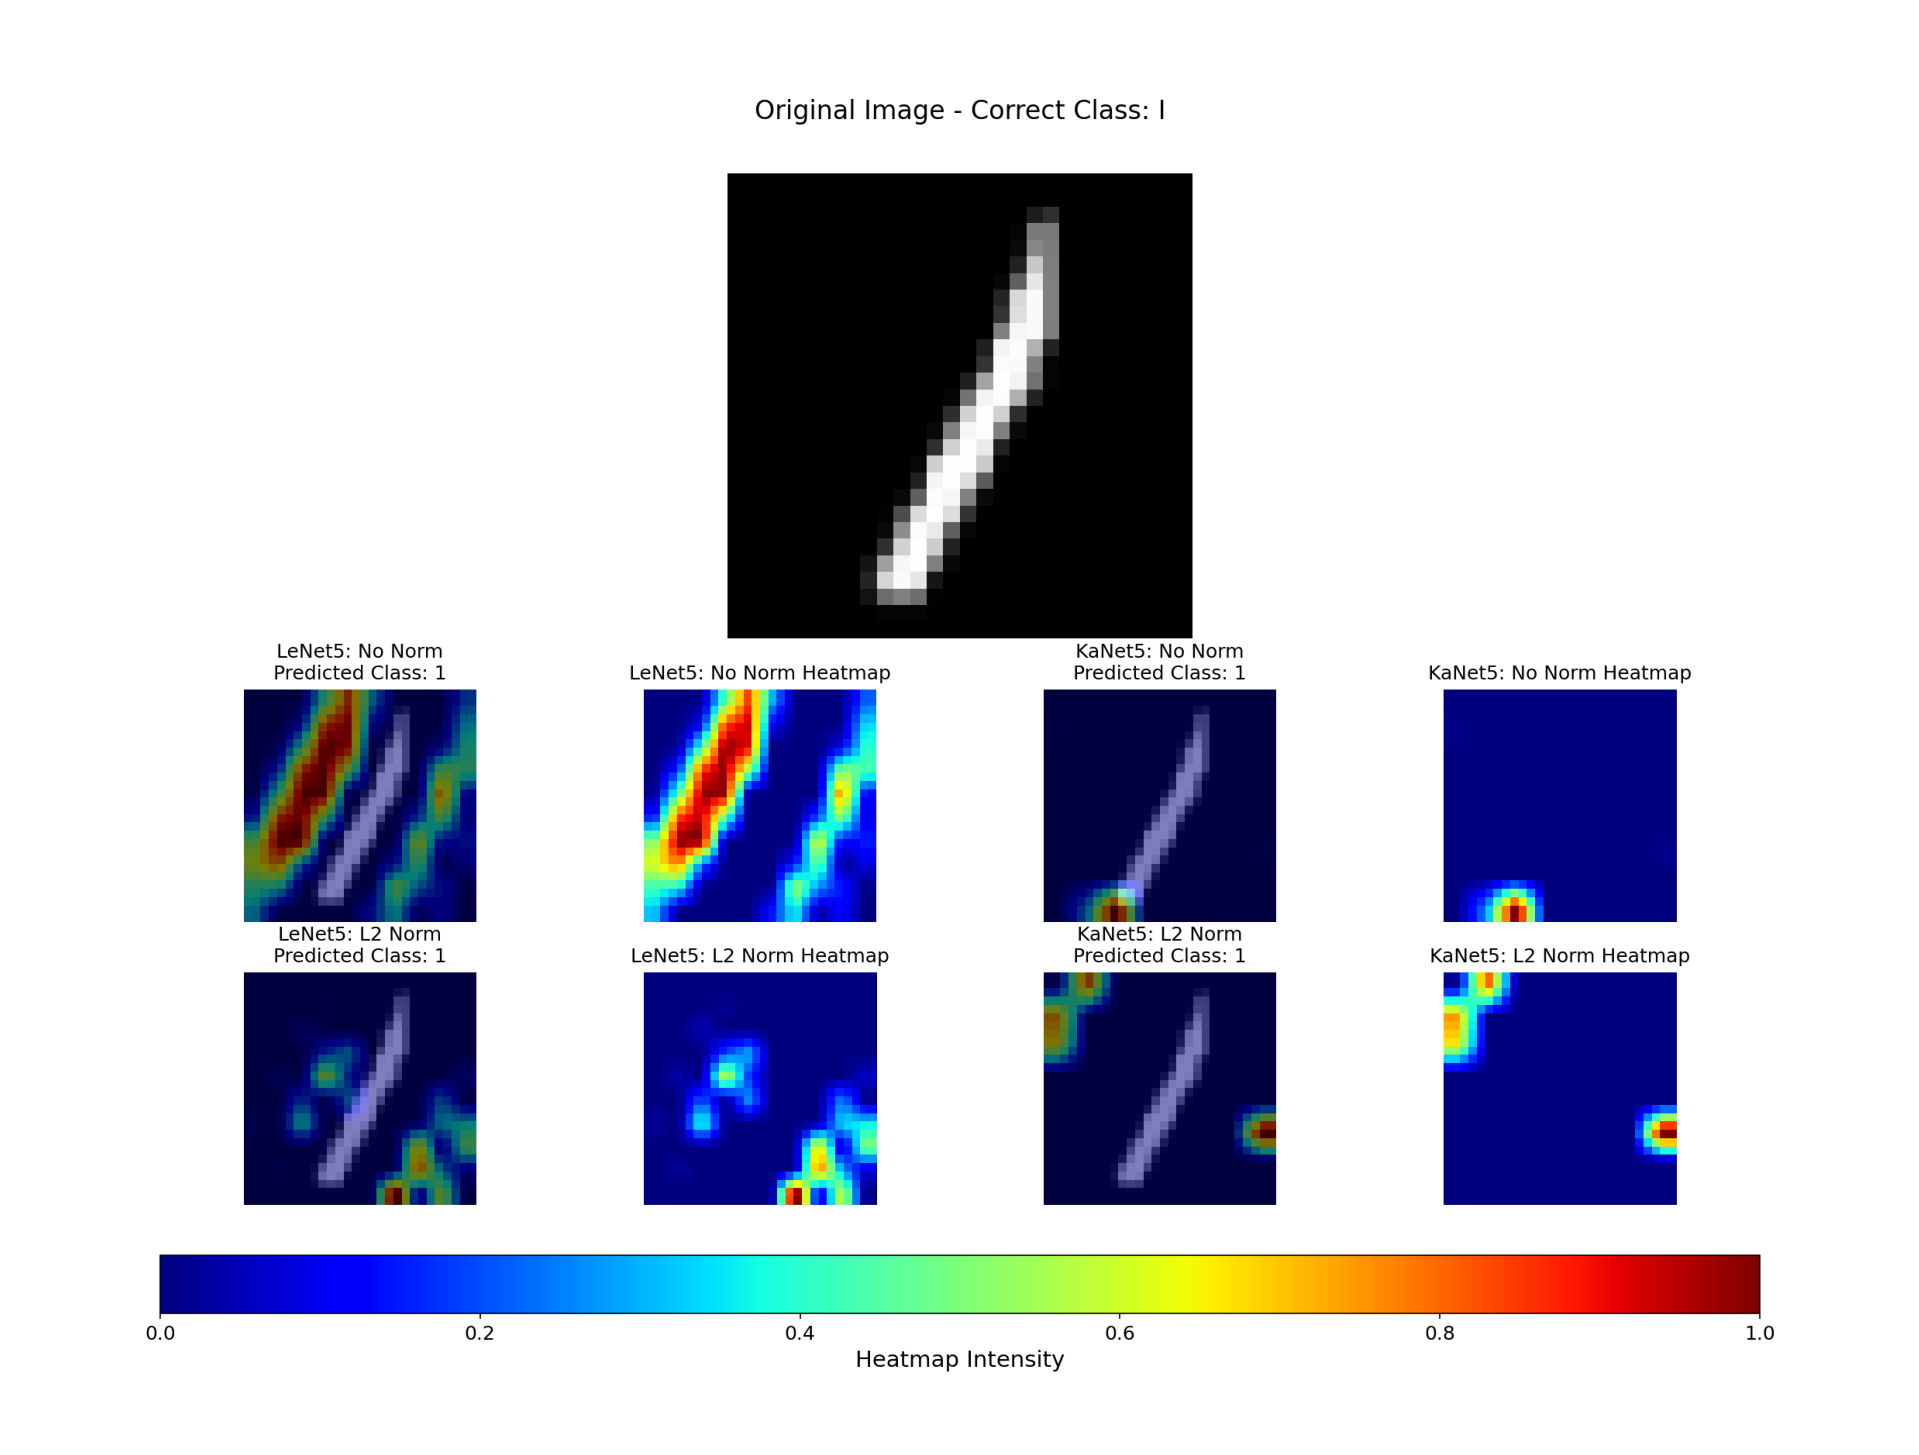

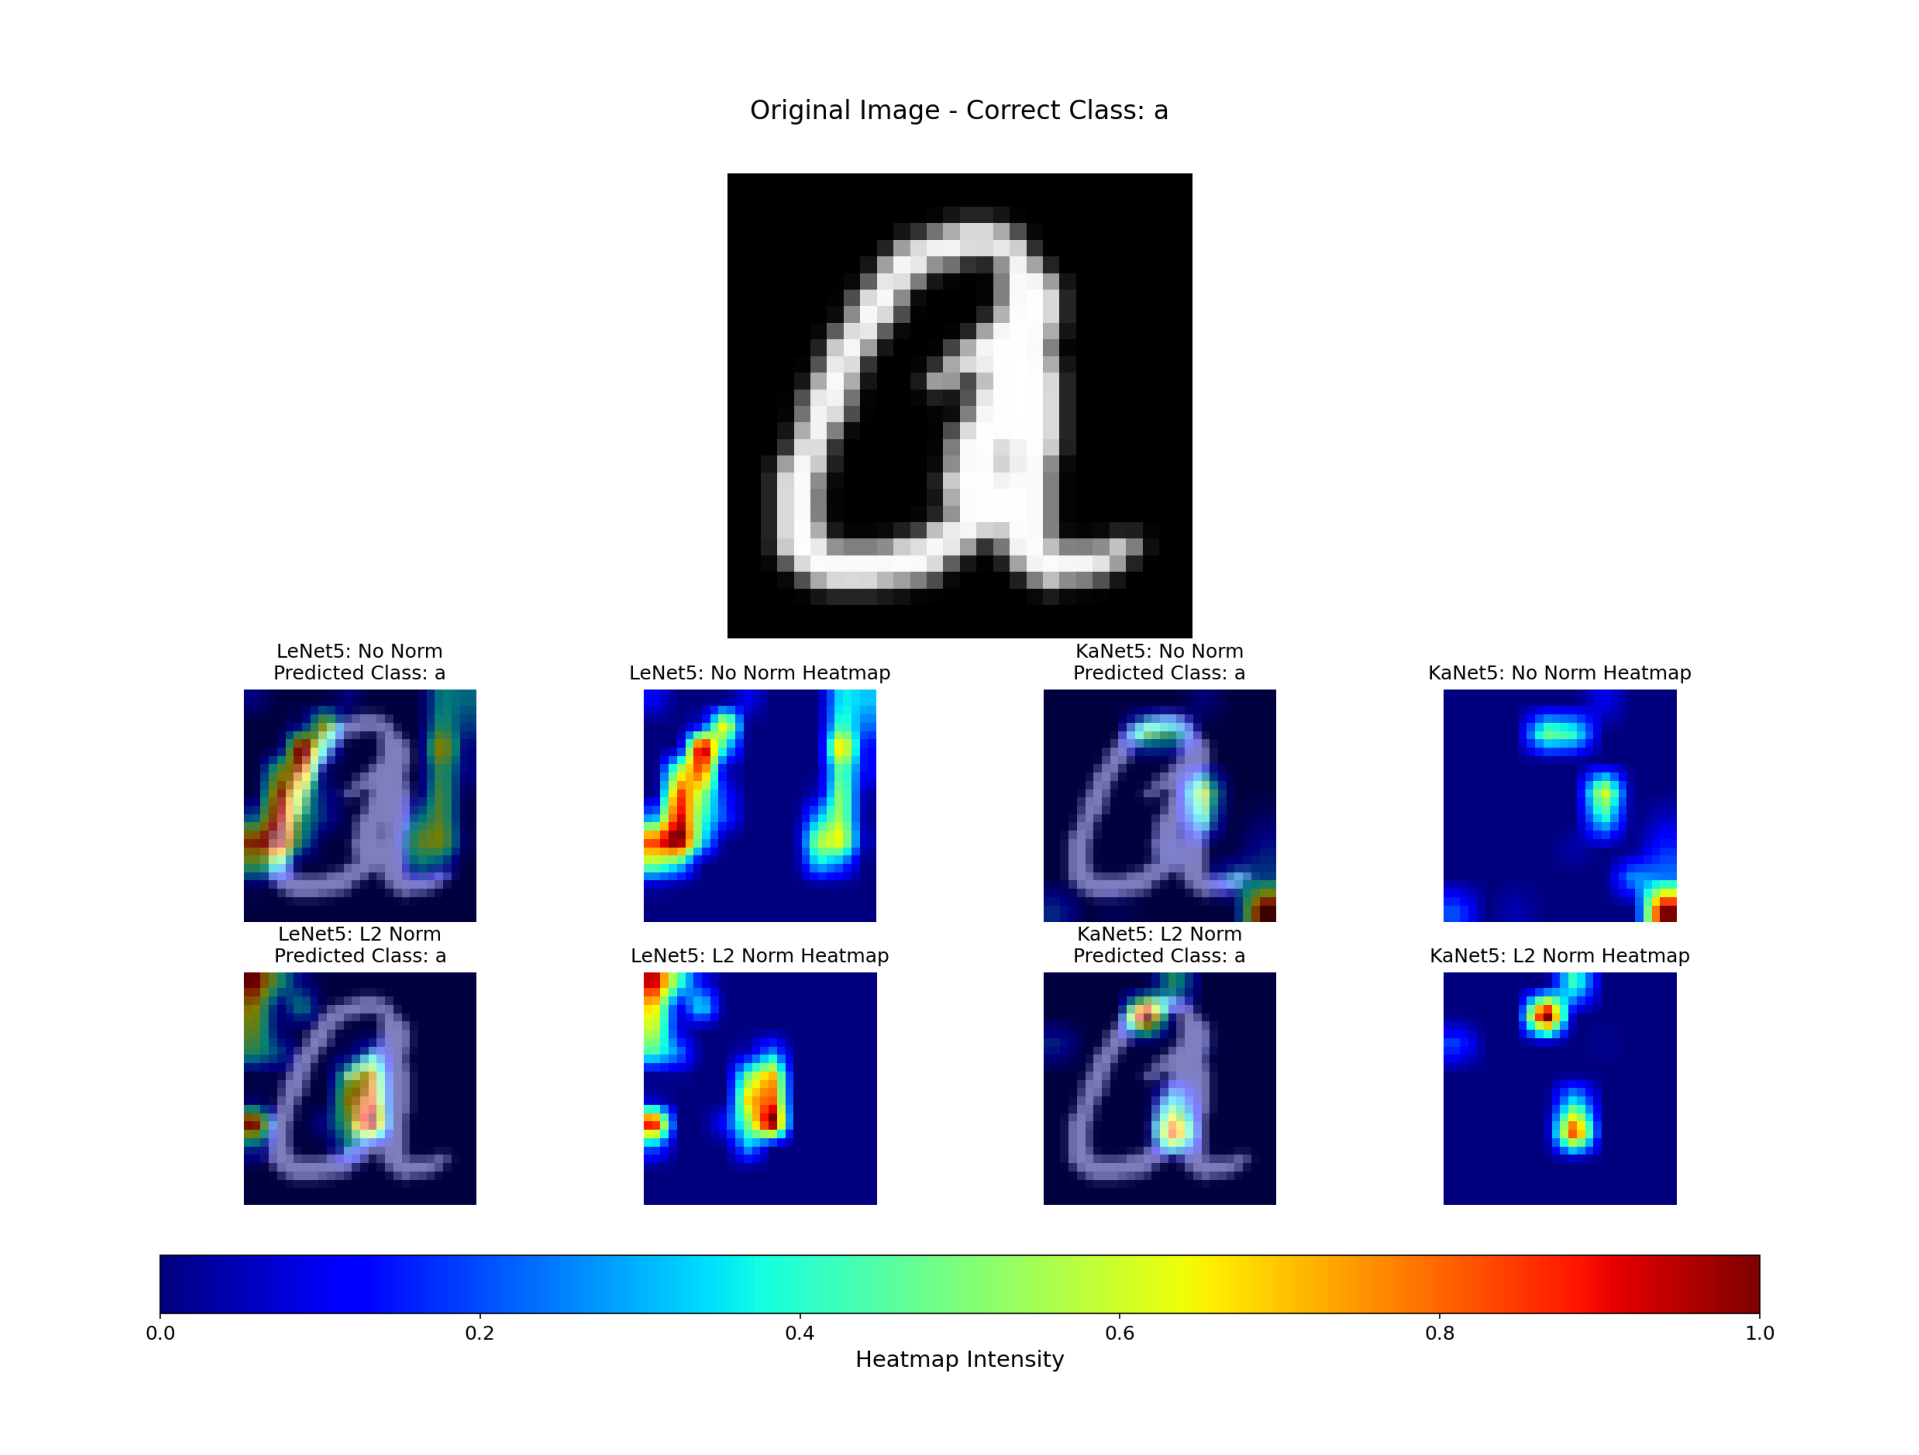

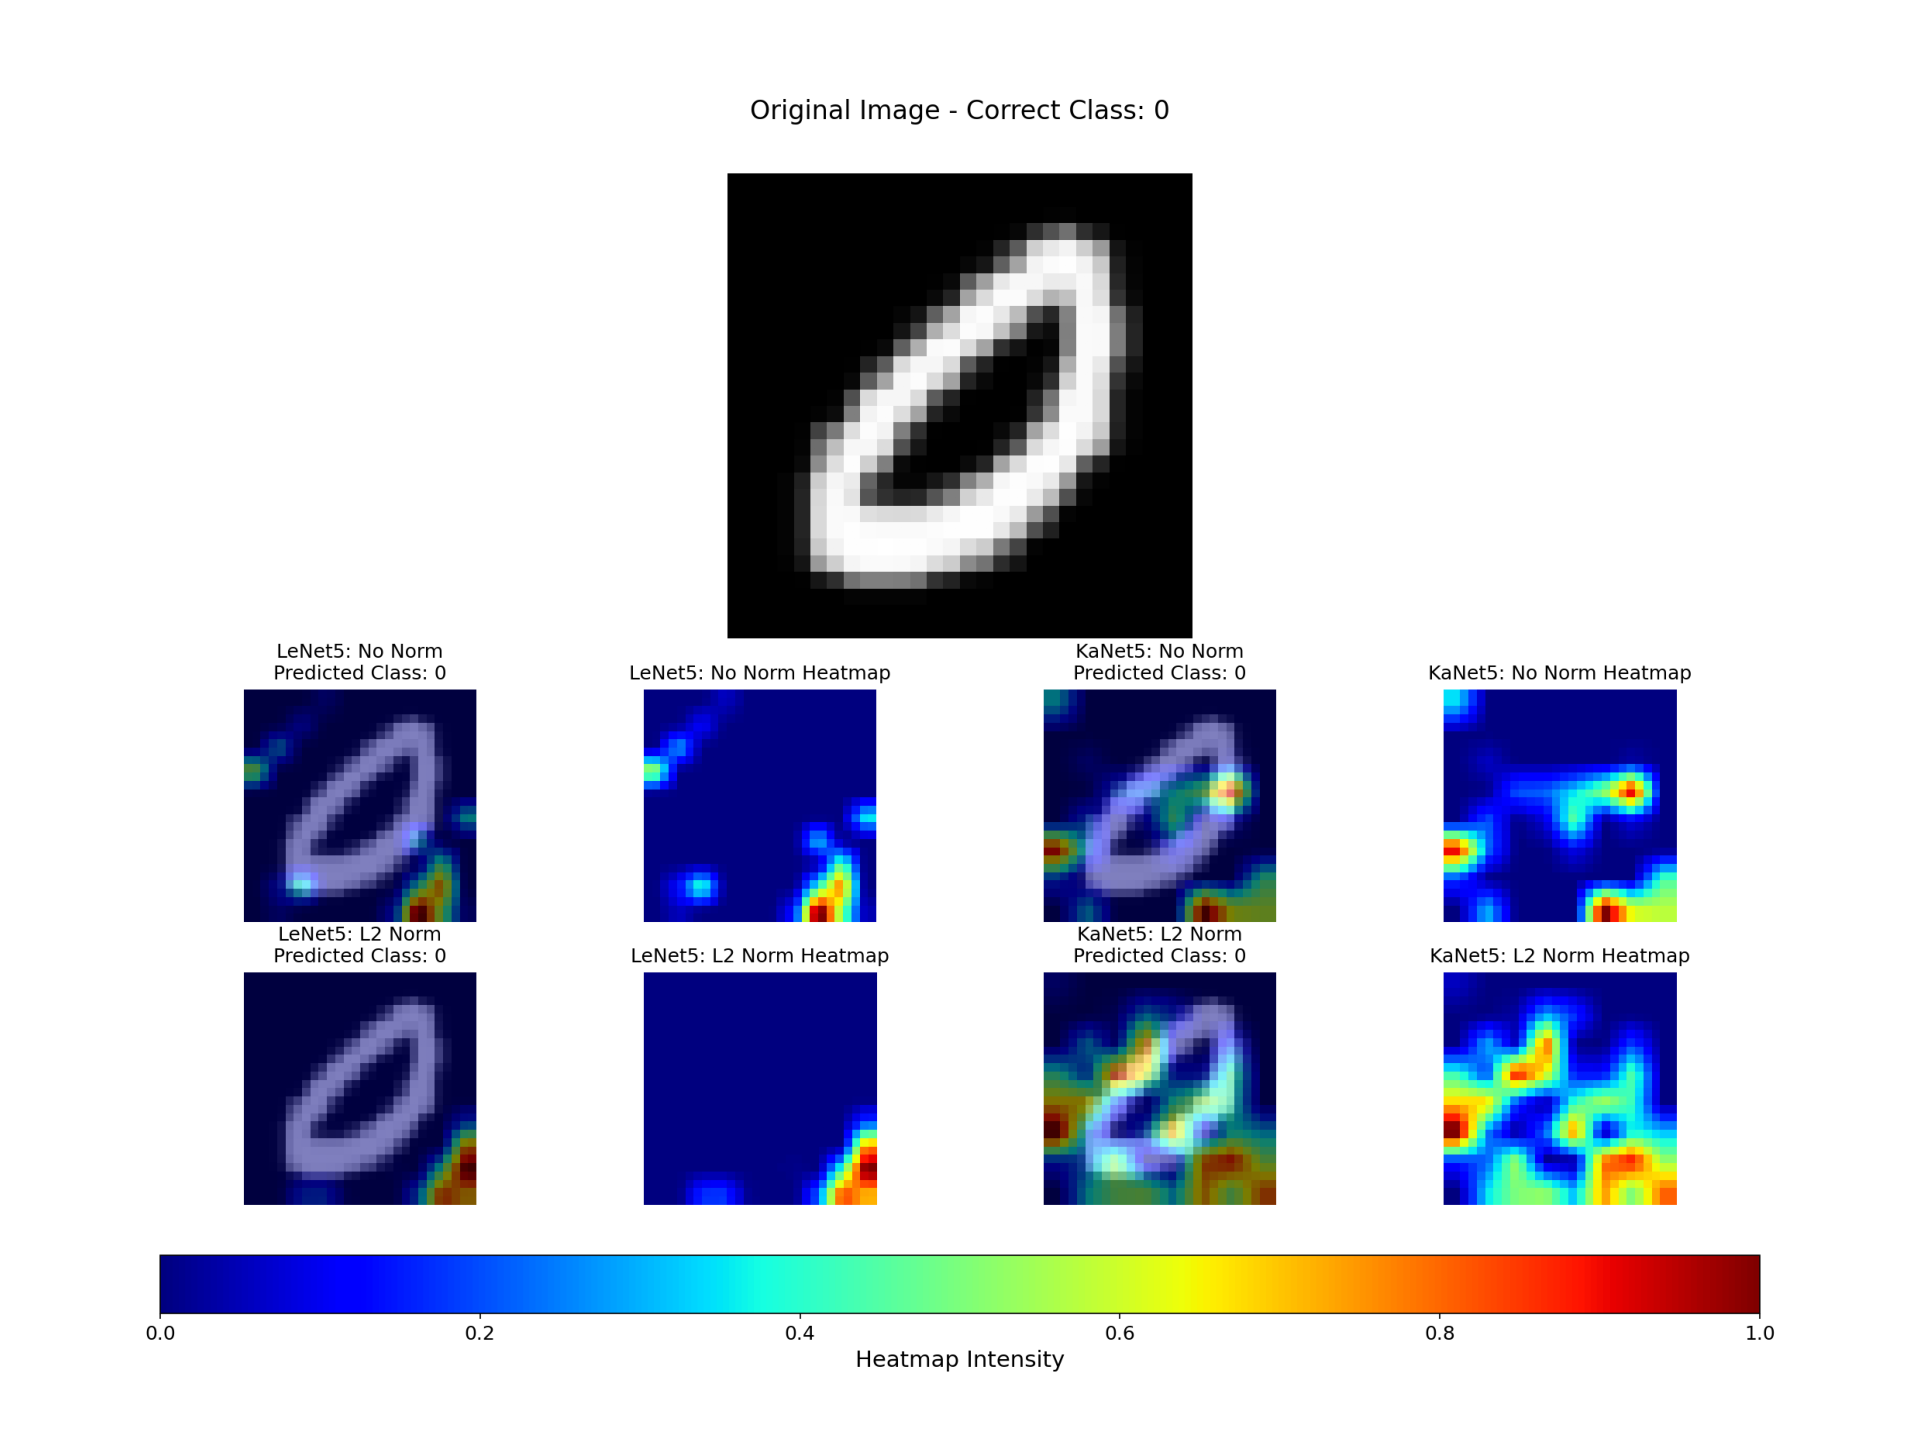

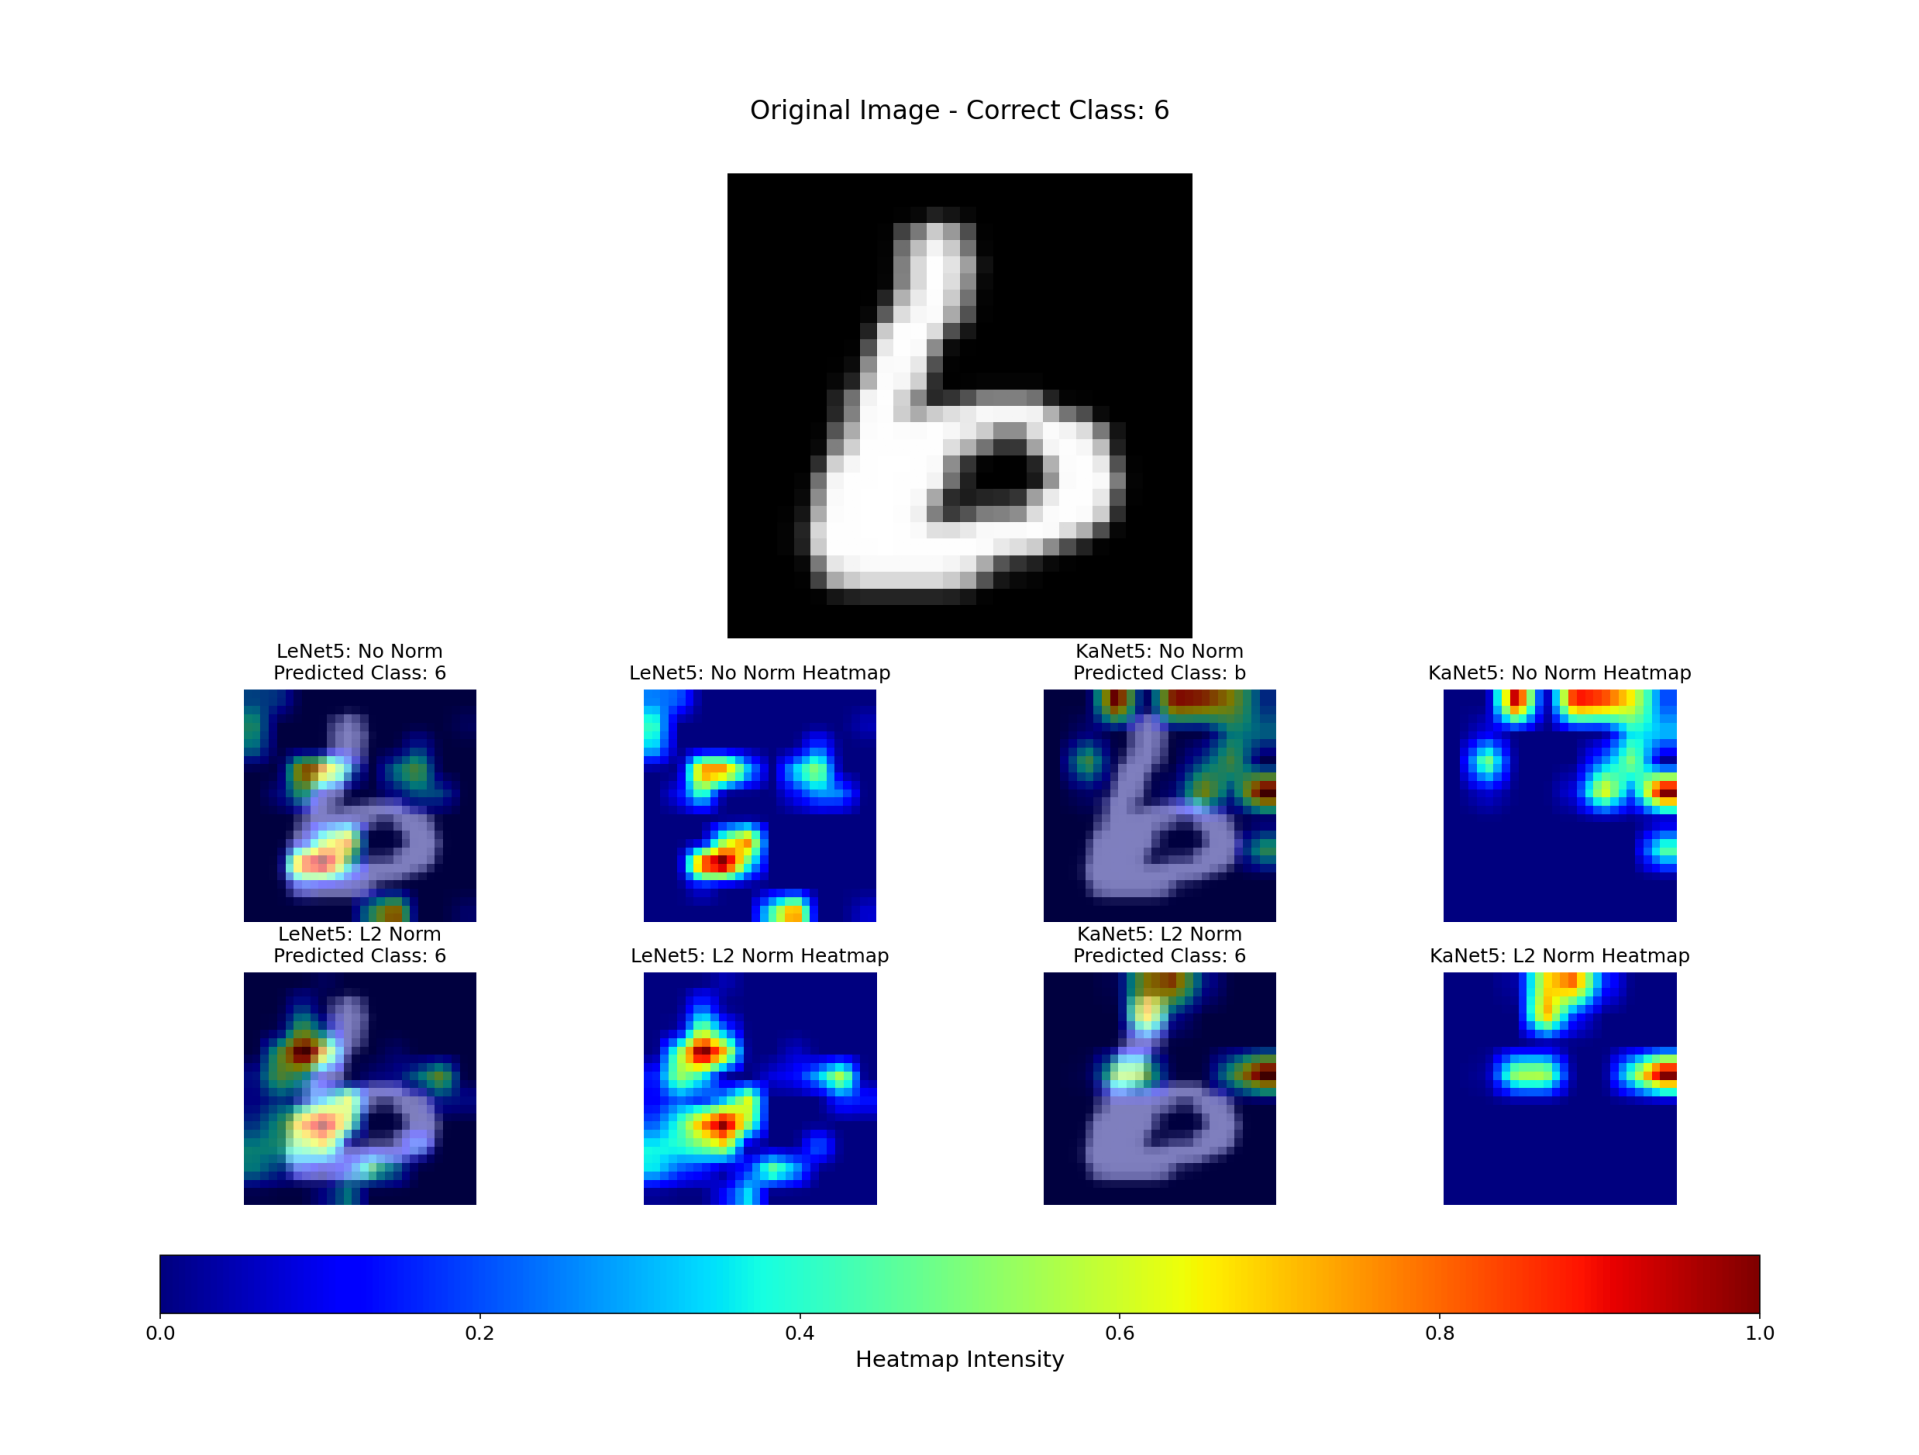

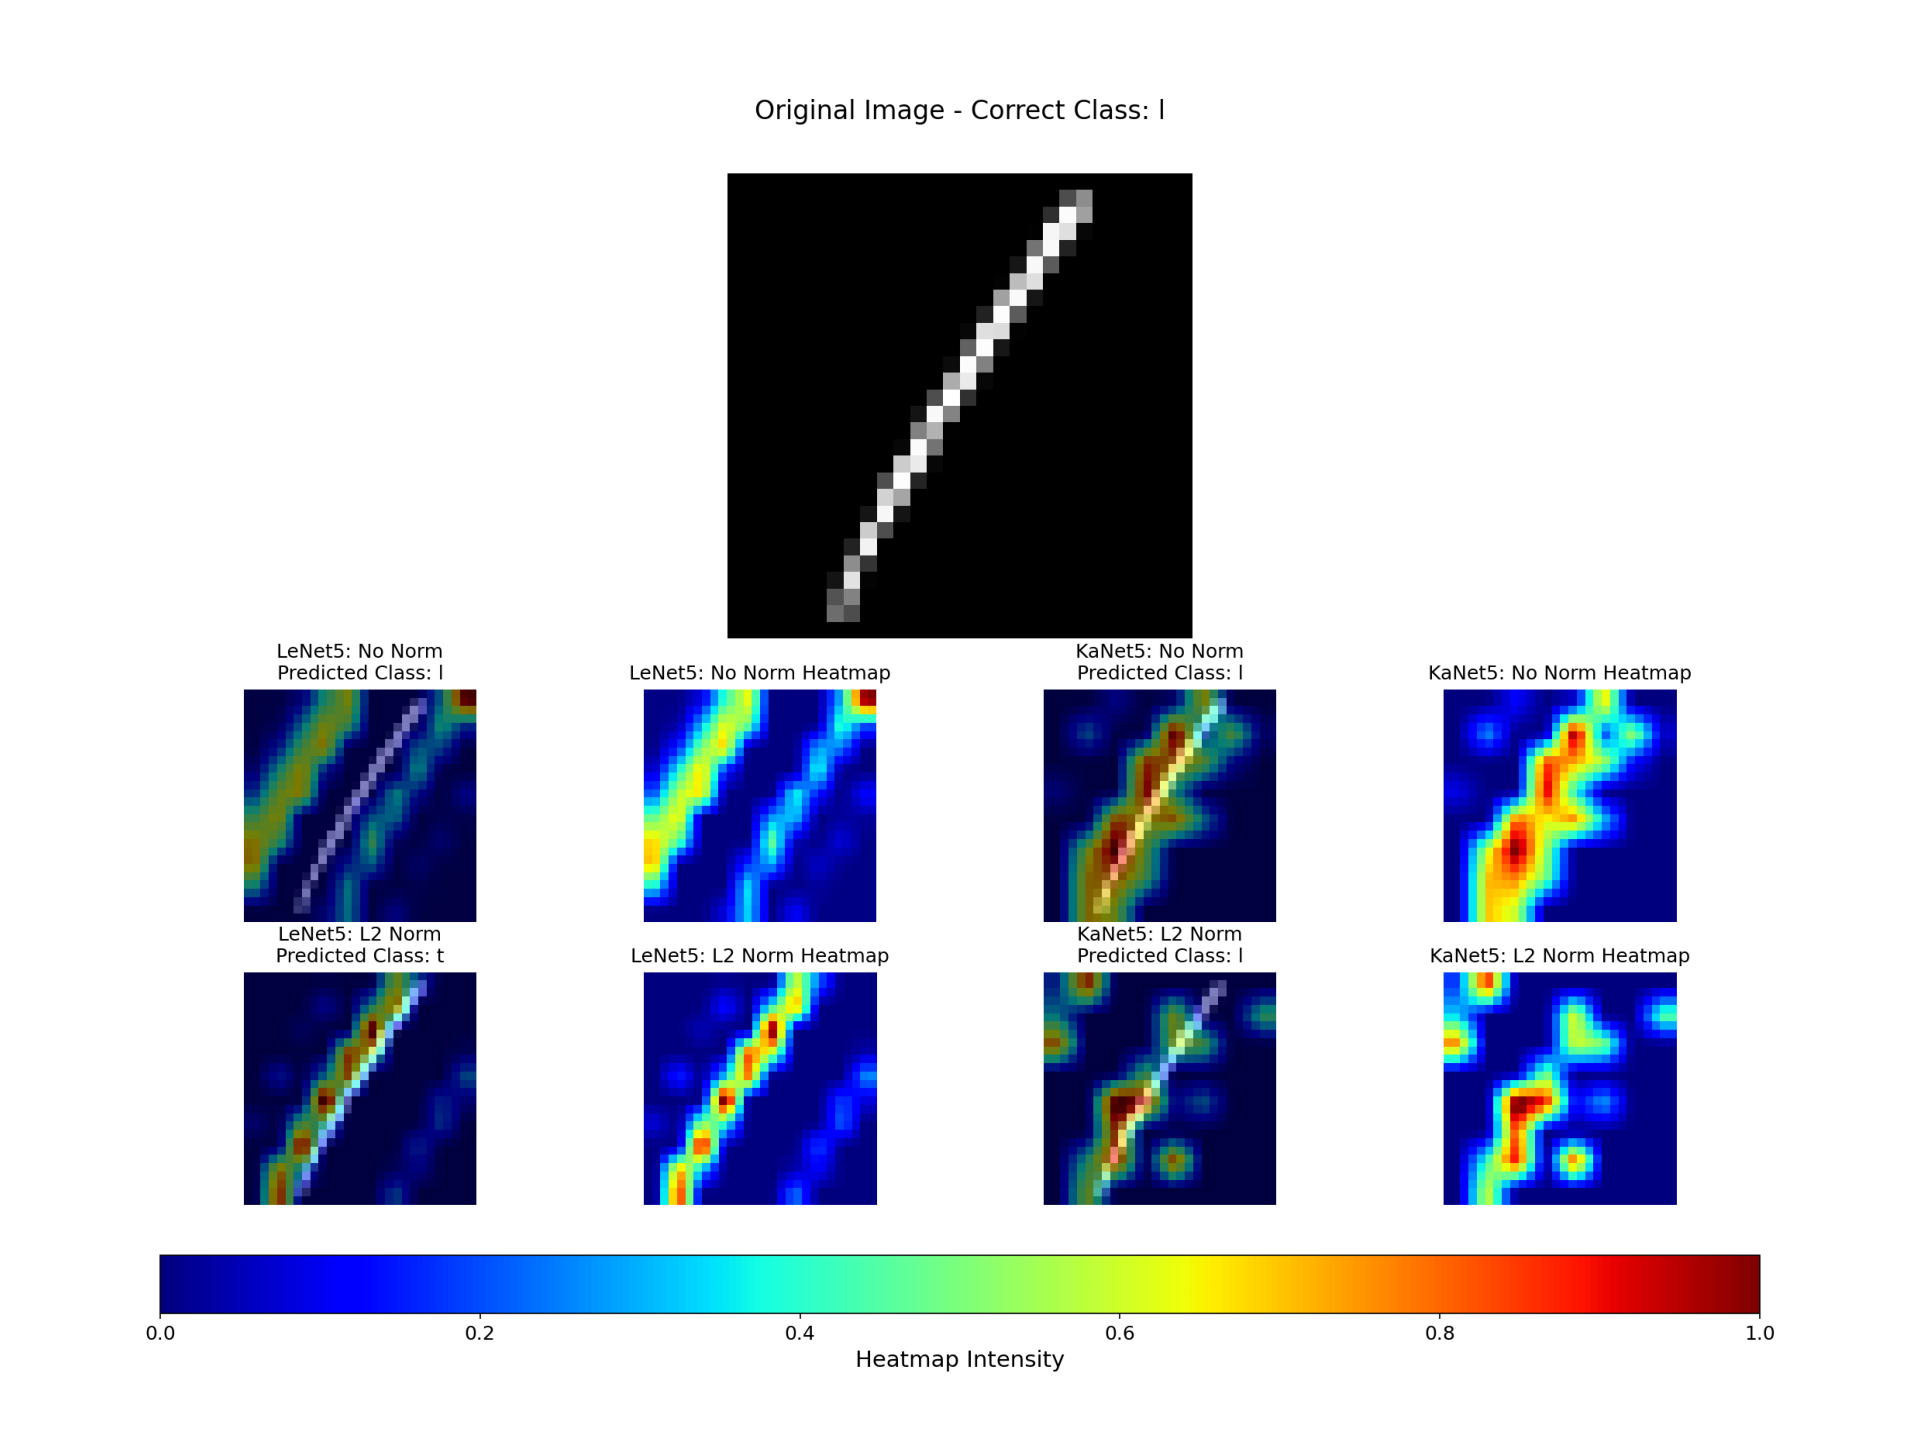

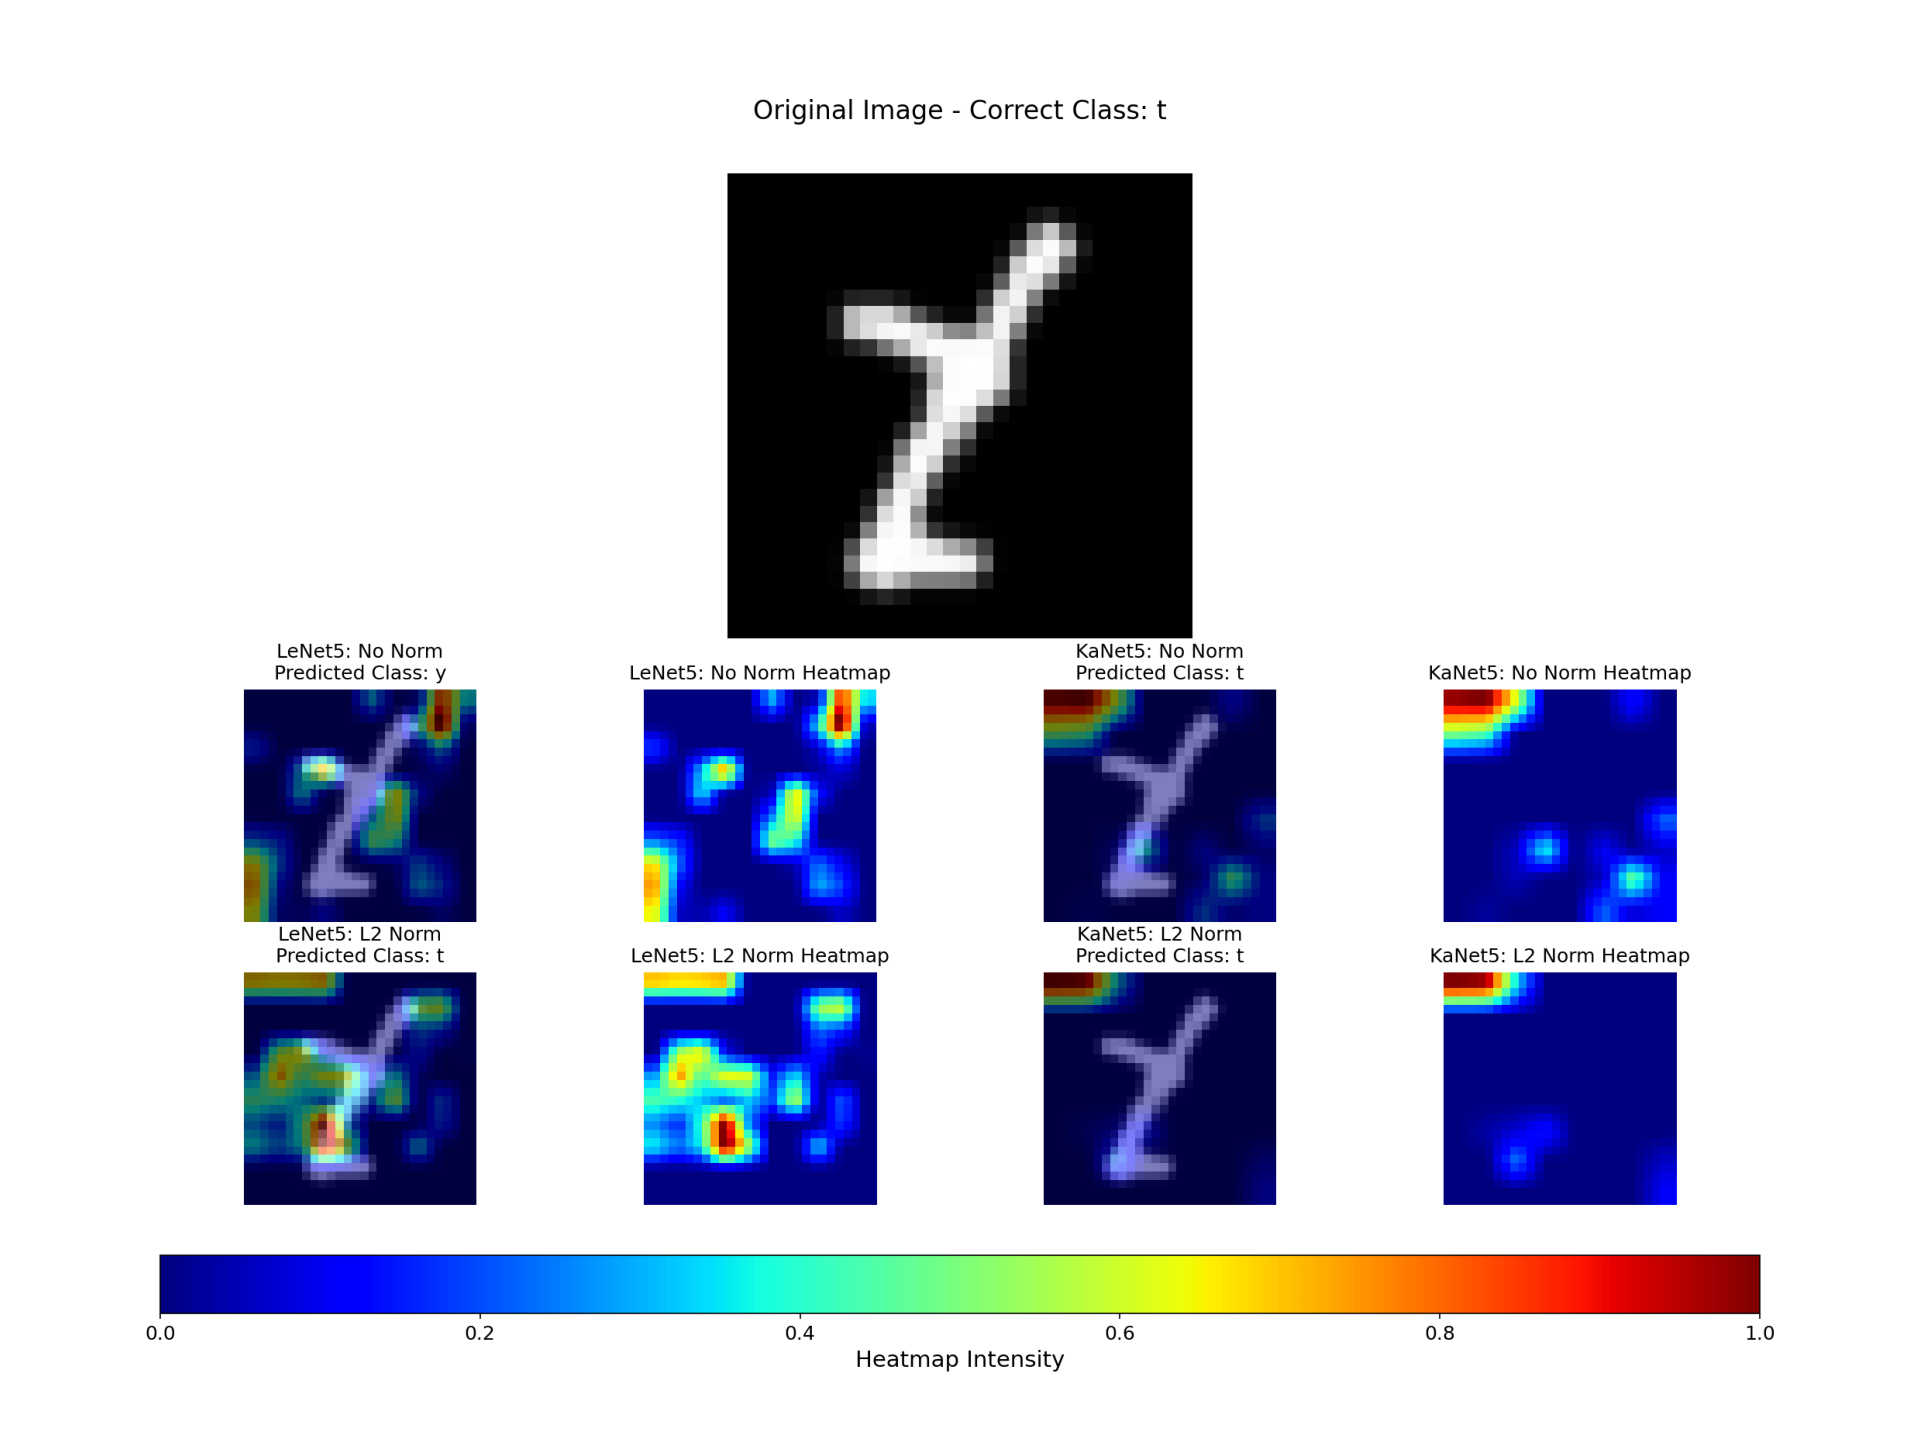

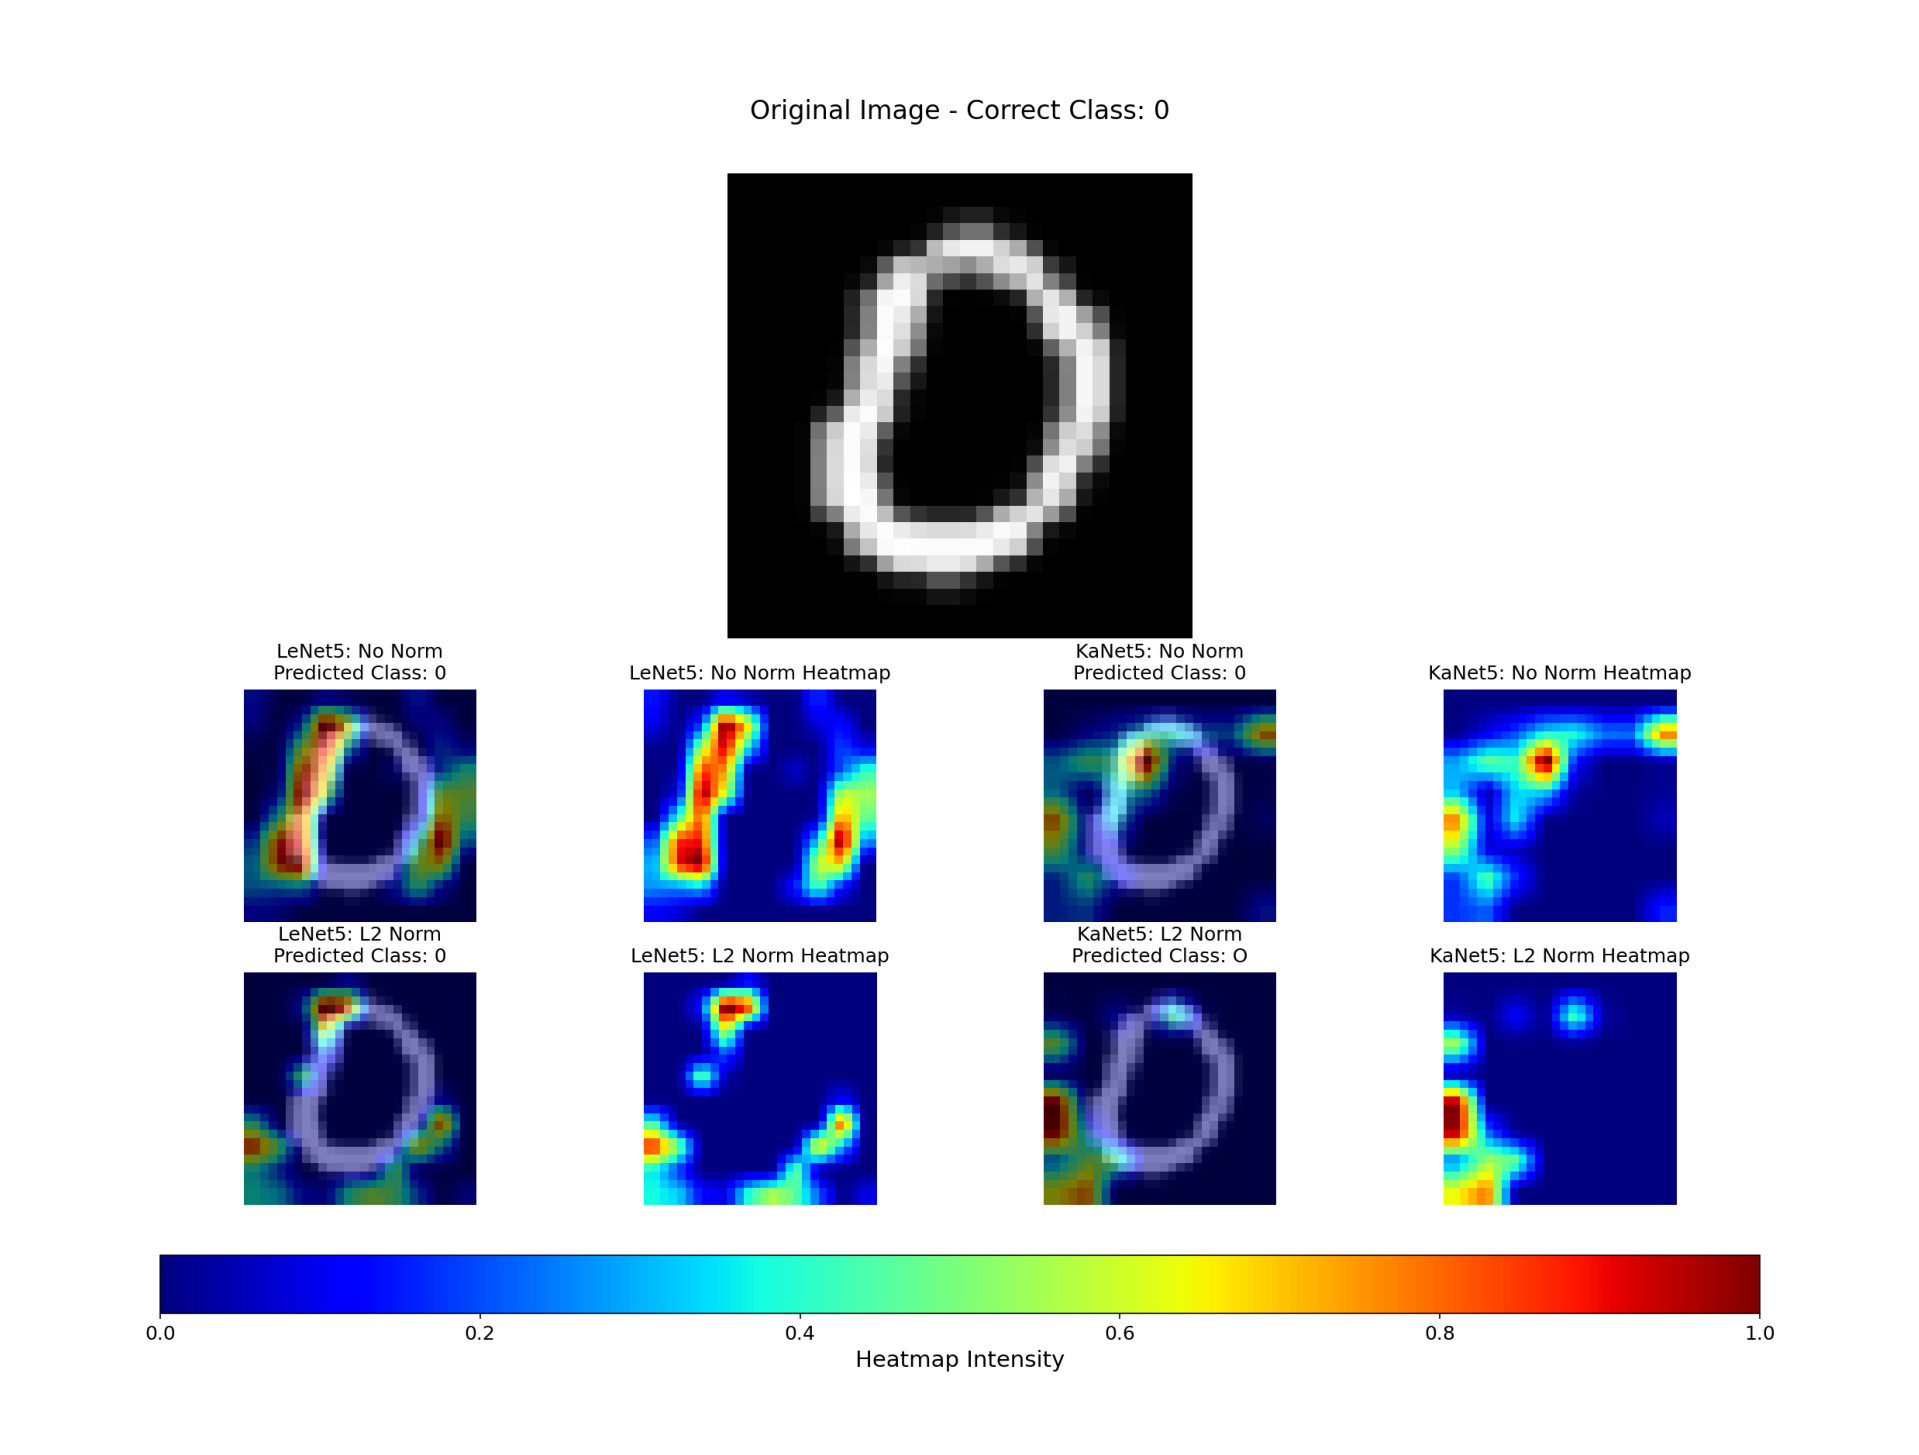

In [5]:
import matplotlib.pyplot as plt
import os

# Lista dei file salvati
chart_files = [
    "final_chart_sample_0.png",
    "final_chart_sample_1.png",
    "final_chart_sample_2.png",
    "final_chart_sample_49.png",
    "final_chart_sample_52.png",
    "final_chart_sample_65.png",
    "final_chart_sample_100.png"
]

# Controllo e visualizzazione delle immagini
for chart_file in chart_files:
    if os.path.exists(chart_file):
        img = plt.imread(chart_file)
        plt.figure(figsize=(8, 8), dpi=300)  # Aumenta dpi per una migliore qualità
        plt.imshow(img)
        plt.axis('off')  # Rimuove gli assi per una visualizzazione pulita
        plt.show()
    else:
        print(f"File {chart_file} non trovato.")


In [6]:
import pandas as pd
import os
from IPython.display import display

# Directory e file per modello
models = {
    "LeNet5: No Norm": "results/results_None_SGD_lr0.01_0_0/Standard_LeNet5/GradCAM/",
    "KaNet5: No Norm": "results/results_None_SGD_lr0.01_5_3/KaNet5/GradCAM/",
    "LeNet5: L2 Norm": "results/results_L2_SGD_lr0.01_0_0/Standard_LeNet5/GradCAM/",
    "KaNet5: L2 Norm": "results/results_L2_SGD_lr0.01_5_3/KaNet5/GradCAM/"
}

# File da considerare
csv_files = ["train_correct.csv", "train_incorrect.csv", "test_correct.csv", "test_incorrect.csv"]

# Legge e visualizza le statistiche per ciascun modello
for model_name, model_path in models.items():
    print(f"=== {model_name} ===\n")
    dfs = []
    for file_name in csv_files:
        file_path = os.path.join(model_path, file_name)
        try:
            # Leggi il CSV
            df = pd.read_csv(file_path)
            # Aggiungi una colonna per descrivere il file
            description = file_name.replace(".csv", "").replace("_", " ").capitalize()
            df.insert(0, "Description", description)
            dfs.append(df)
        except FileNotFoundError:
            print(f"File non trovato: {file_path}")
    
    # Concatenazione e visualizzazione
    if dfs:
        combined_df = pd.concat(dfs, ignore_index=True)
        display(combined_df)
    else:
        print("Nessun file disponibile per questo modello.\n")


=== LeNet5: No Norm ===



,Description,mean_intensity,variance_intensity,max_intensity
0,Train correct,5.440341,167.731094,91.789970
1,Train incorrect,5.334188,156.757812,85.210648
2,Test correct,5.440900,167.764359,91.807999
3,Test incorrect,5.347645,158.631439,86.198540


=== KaNet5: No Norm ===



,Description,mean_intensity,variance_intensity,max_intensity
0,Train correct,0.536035,427.624939,70.927231
1,Train incorrect,0.561196,367.806702,62.290306
2,Test correct,0.540707,427.426666,70.952354
3,Test incorrect,0.557997,374.891510,63.157063


=== LeNet5: L2 Norm ===



,Description,mean_intensity,variance_intensity,max_intensity
0,Train correct,6.342367,219.083313,103.019150
1,Train incorrect,6.156100,201.739182,95.141525
2,Test correct,6.343664,219.131668,103.083282
3,Test incorrect,6.171502,204.006851,96.152519


=== KaNet5: L2 Norm ===



,Description,mean_intensity,variance_intensity,max_intensity
0,Train correct,0.910028,576.164246,81.579407
1,Train incorrect,0.816573,493.616119,71.456688
2,Test correct,0.915170,575.786743,81.592850
3,Test incorrect,0.814378,503.853394,72.541130
